In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt  
%matplotlib inline
import seaborn as sns
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 
from scipy import stats
from scipy.stats import norm, skew 
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# IMPORTING TRAINING AND TESTING DATA
train_data = pd.read_csv("train.csv")
test_data  = pd.read_csv("test.csv")

In [3]:
#Save the 'Id' column
train_ID = train_data['Id']
test_ID = test_data['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train_data.drop("Id", axis = 1, inplace = True)
test_data.drop("Id", axis = 1, inplace = True)

# EXPLORATORY DATA ANALYSIS

To understand the meaning and the distribution of the features and study the relationships between features.

Scatter Plot to check for Raw Outliers

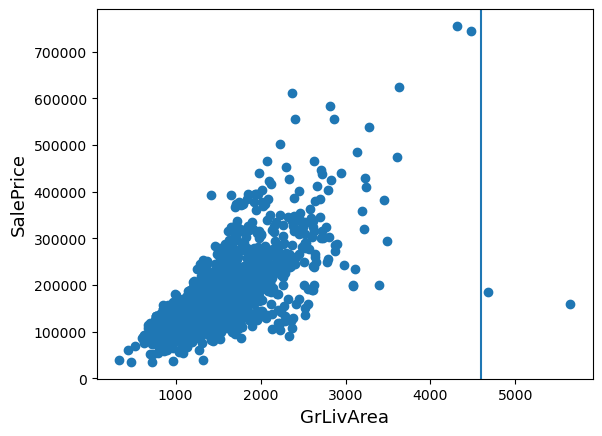

In [7]:
fig, ax = plt.subplots()
ax.scatter(x = train_data['GrLivArea'], y = train_data['SalePrice'])
ax.axvline(4600)
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

We can see at the bottom right two with extremely large GrLivArea that are of a low price. These values are huge oultliers. Therefore, we can safely delete them.

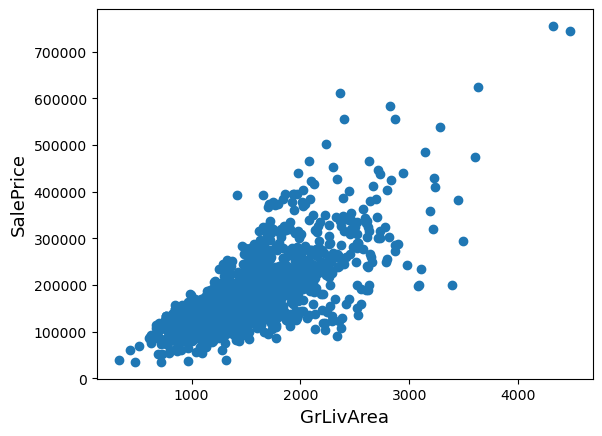

In [9]:
#Removing Outliers identified from above graph
train_data = train_data[train_data["GrLivArea"]<4600]

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(x = train_data['GrLivArea'], y = train_data['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

NUMERICAL VARIABLES

Discrete Values

In [12]:
numerical_features=[]
print(train_data['MSSubClass'].dtype)
for feature in train_data:
    if train_data[feature].dtype!='O' and feature!= 'SalePrice':
        numerical_features.append(feature)

discrete_variables=[]
for feature in numerical_features:
    if len(train_data[feature].unique())<=25 and feature != 'SalePrice':
        discrete_variables.append(feature)

print(discrete_variables)

int64
['MSSubClass', 'OverallQual', 'OverallCond', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', '3SsnPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


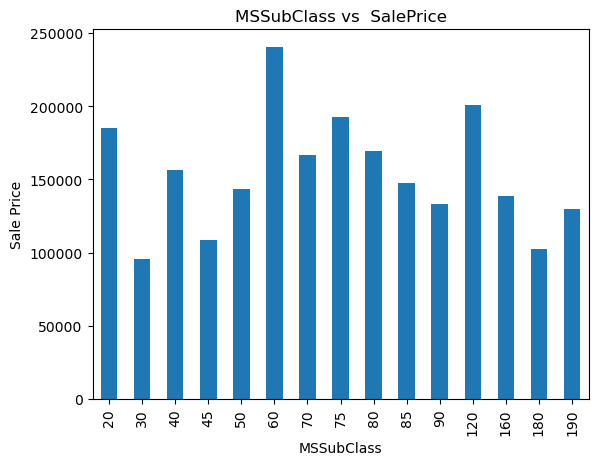

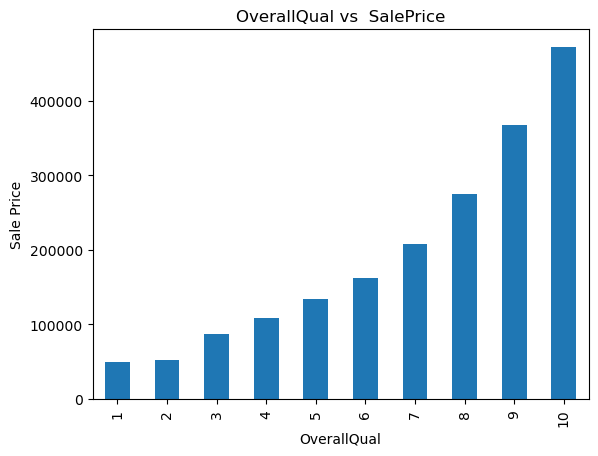

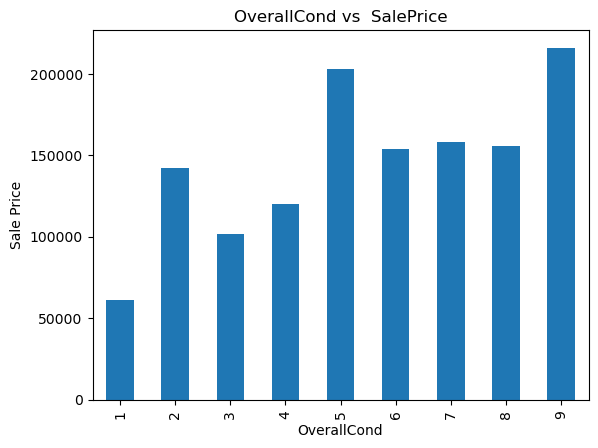

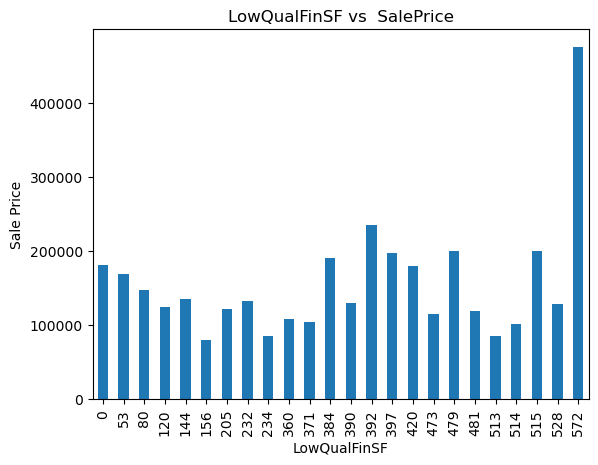

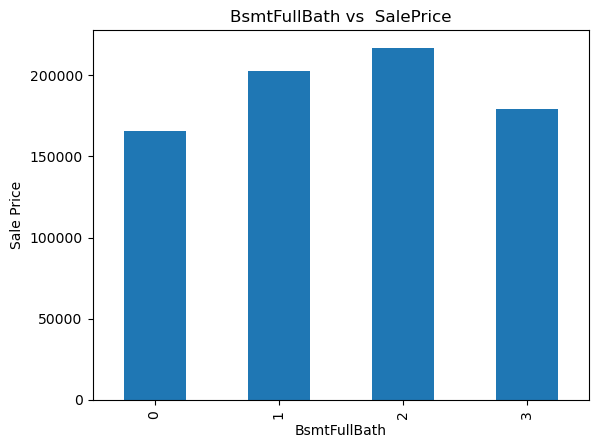

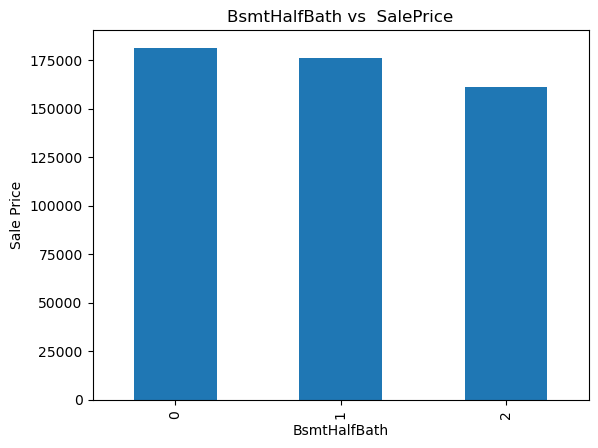

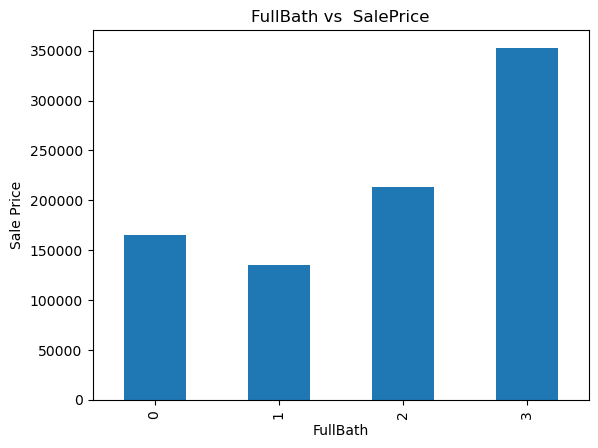

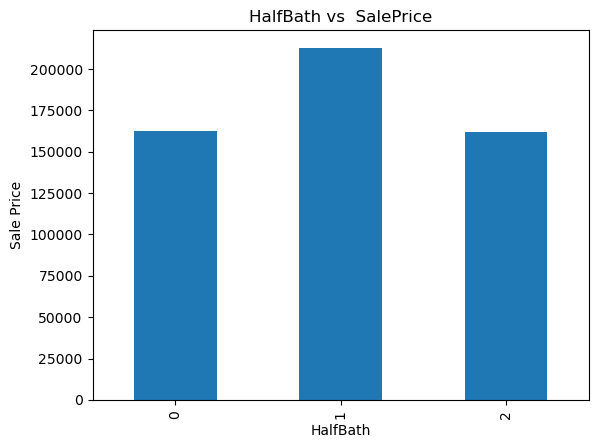

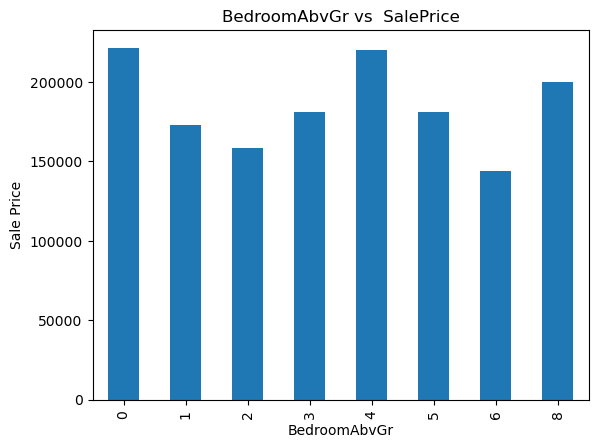

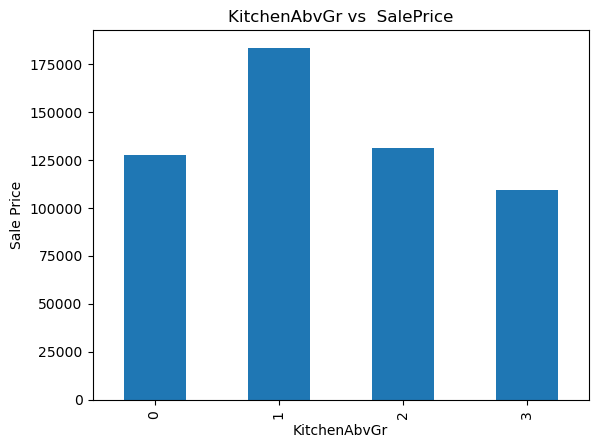

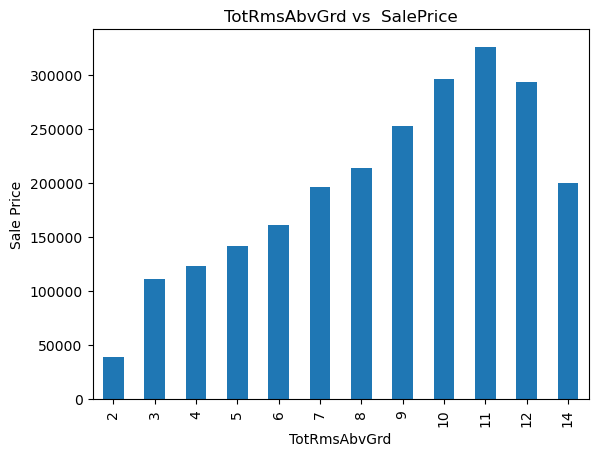

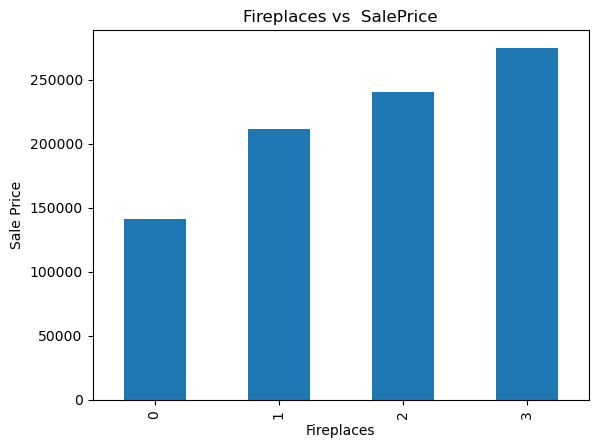

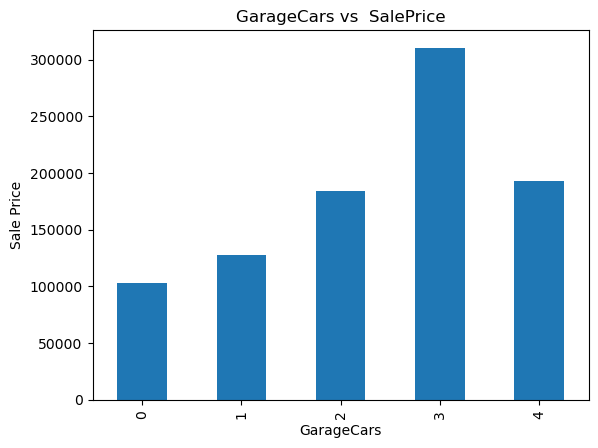

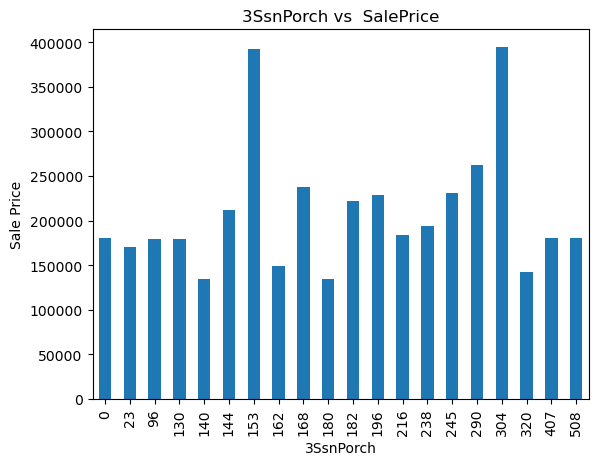

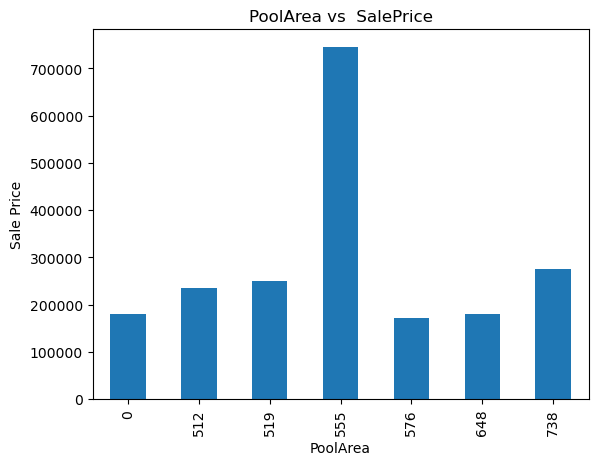

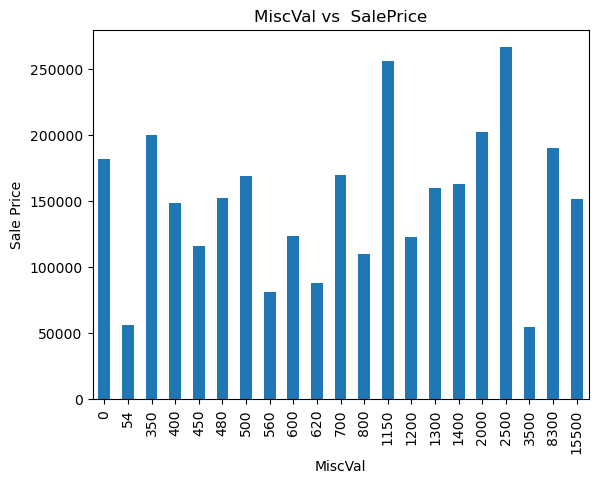

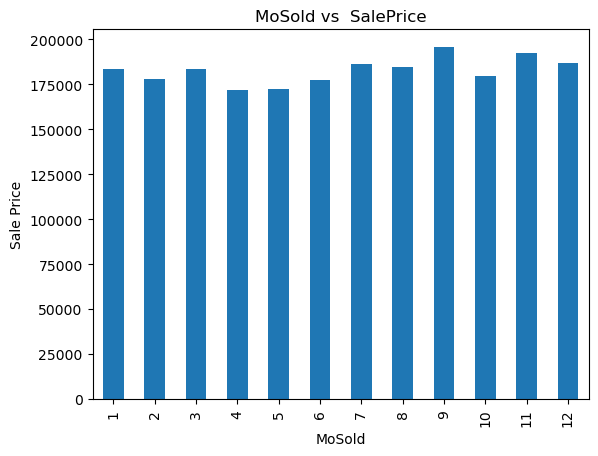

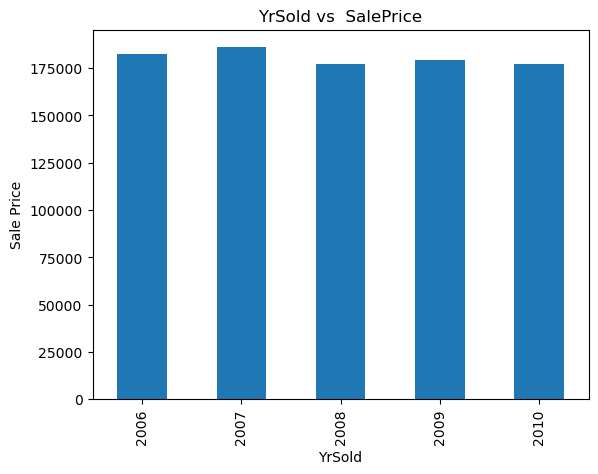

In [13]:
for feature in discrete_variables:
     train_data.groupby(feature)['SalePrice'].mean().plot.bar()
     plt.xlabel(feature)
     plt.ylabel('Sale Price')
     plt.title(feature +' vs '+' SalePrice')
     plt.show()

Continuous Values

In [15]:
continuous_variables=[]
for feature in numerical_features:
    if feature not in discrete_variables and feature not in ["YearBuilt","YearRemodAdd","GarageYrBlt","YrSold"]:
        continuous_variables.append(feature)

print(continuous_variables)

['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch']


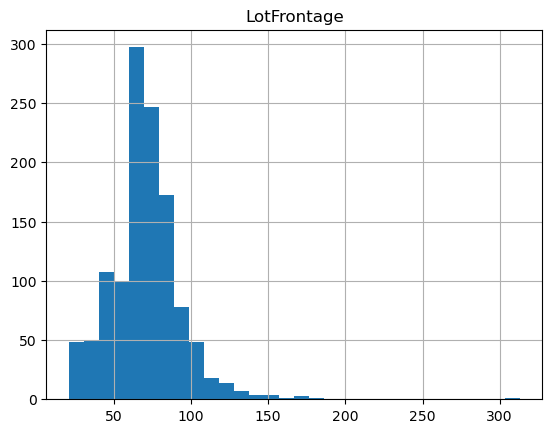

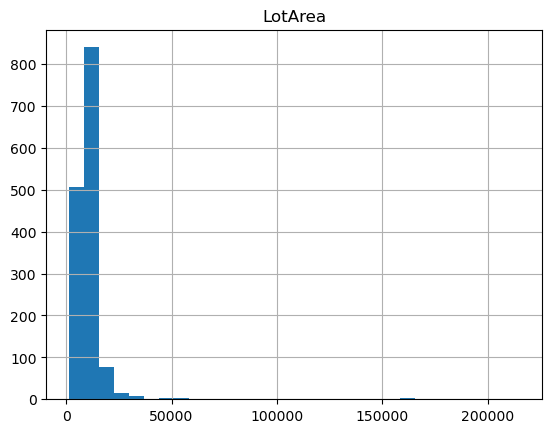

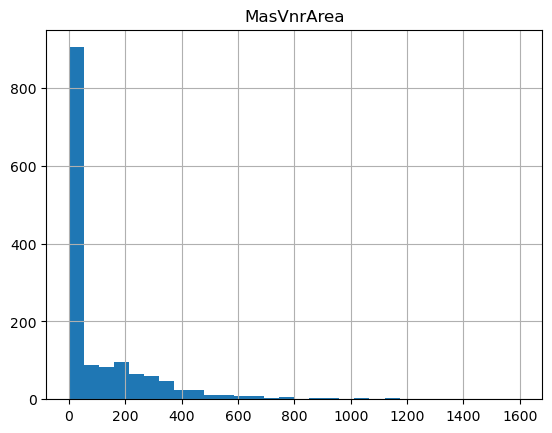

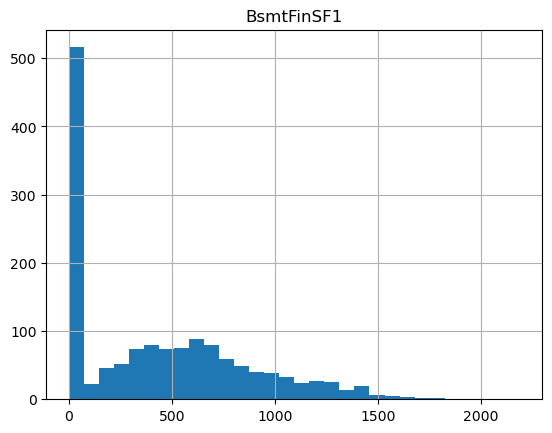

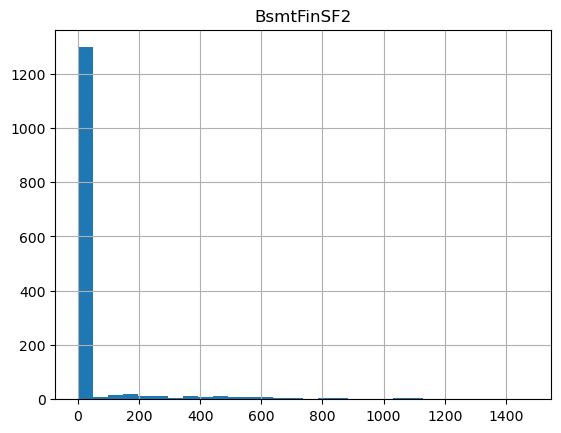

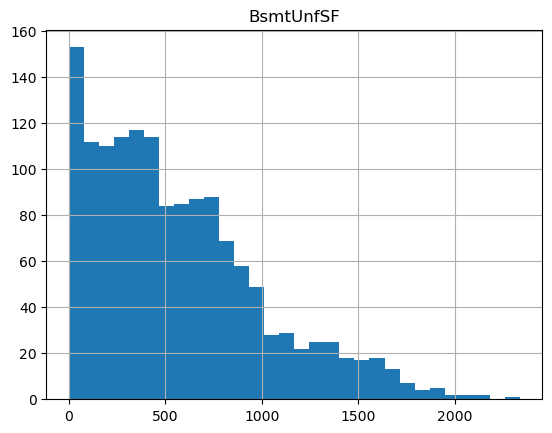

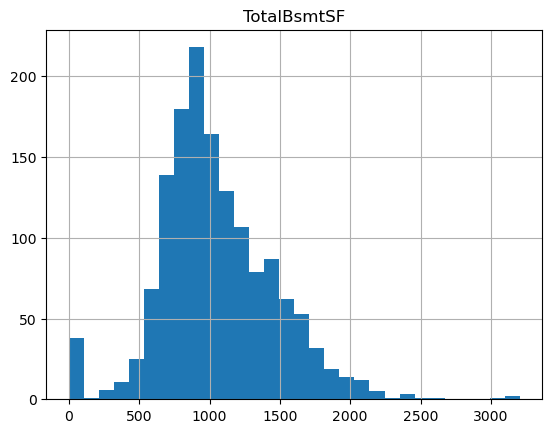

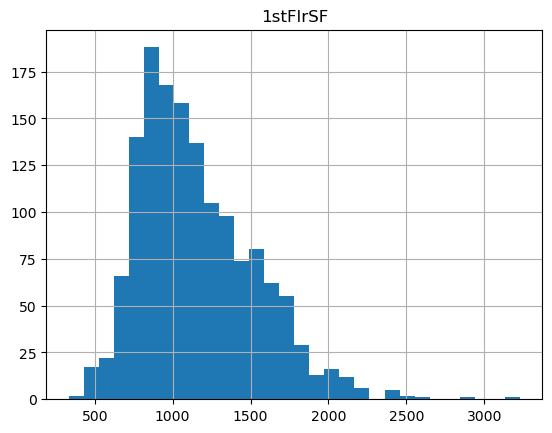

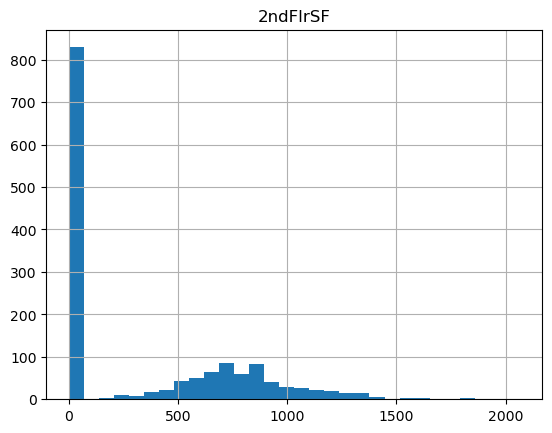

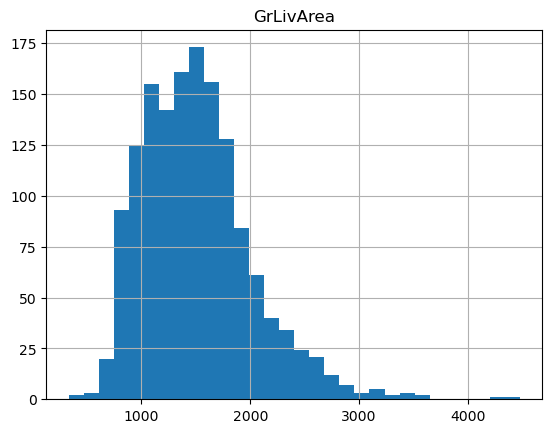

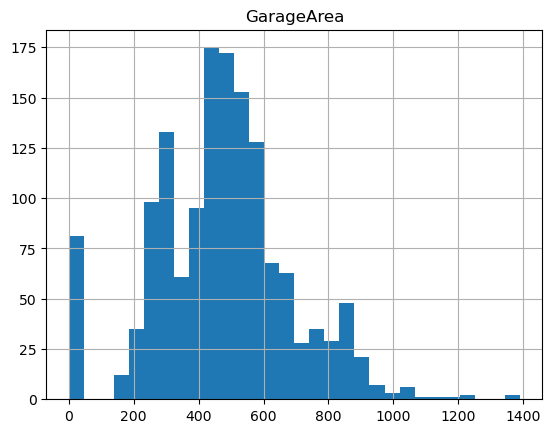

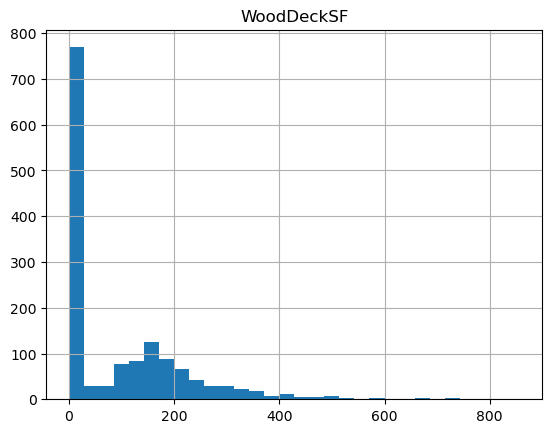

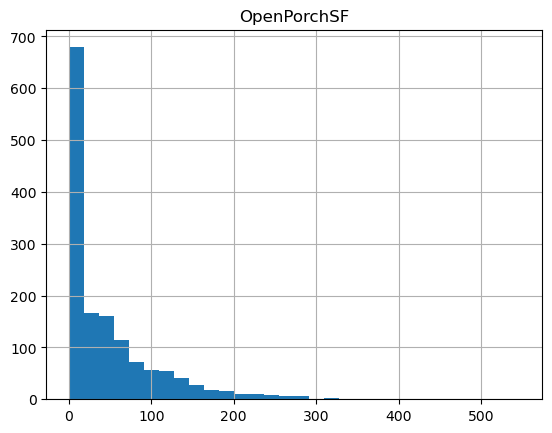

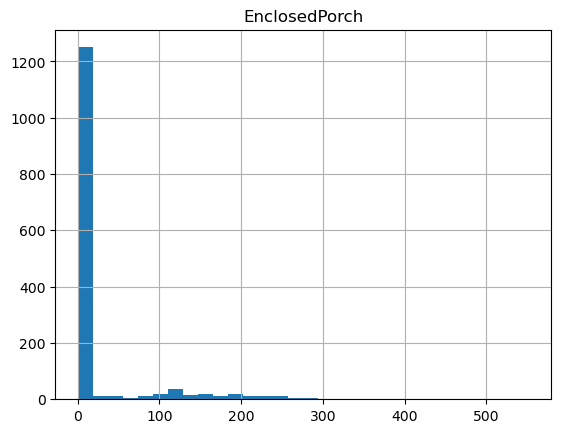

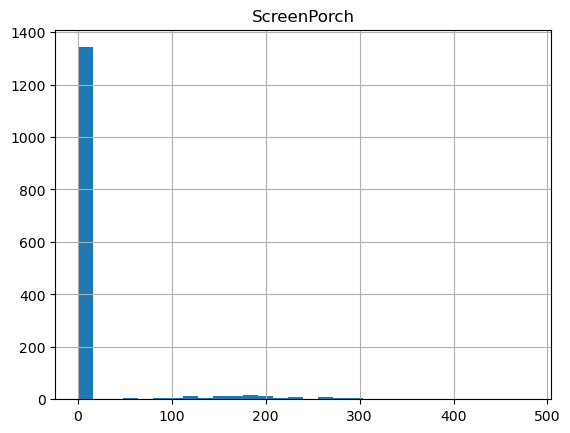

In [16]:
for feature in continuous_variables:
     train_data[feature].hist(bins=30)
     plt.title(feature)
     plt.show()

CATEGORICAL VARIABLES

In [18]:
categorical_features=[]
for feature in train_data.columns:
    if train_data[feature].dtype=='O'and feature!= 'SalePrice':
        categorical_features.append(feature)
print(categorical_features)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


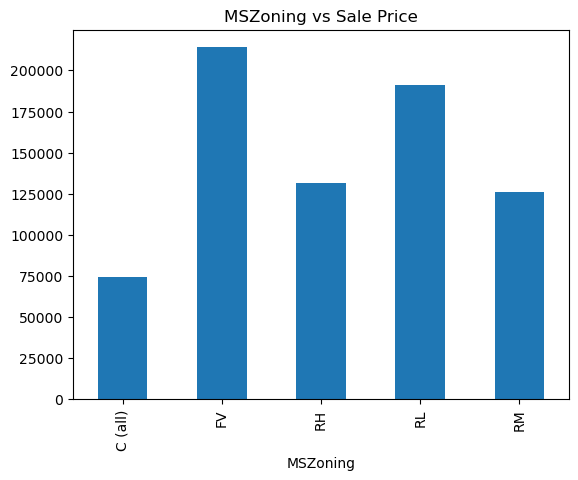

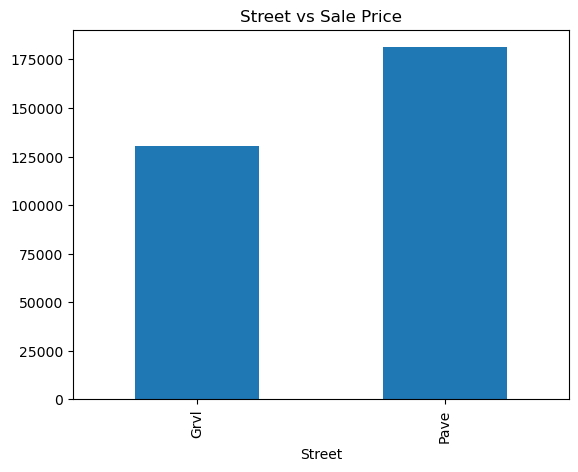

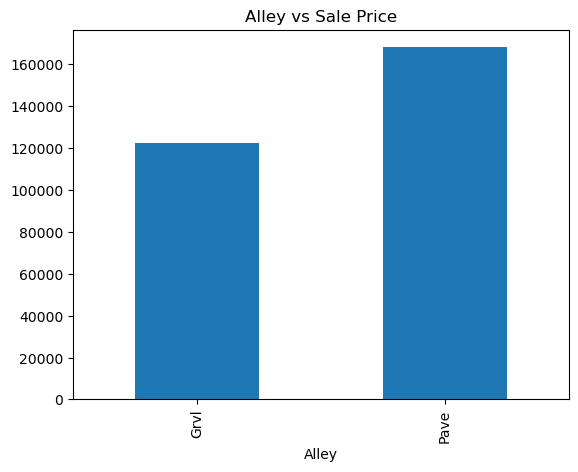

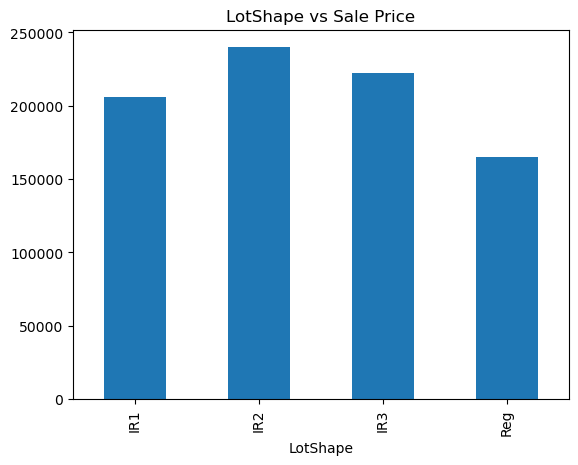

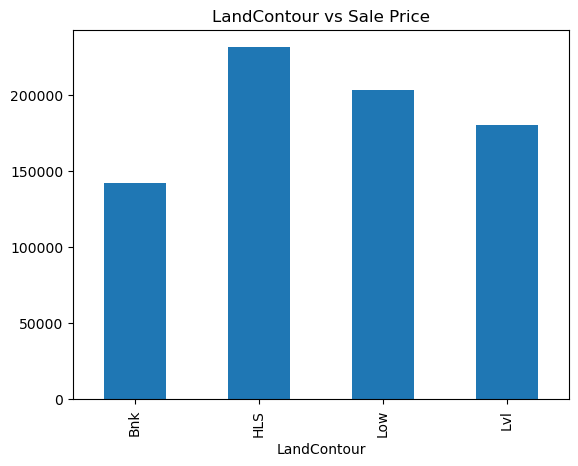

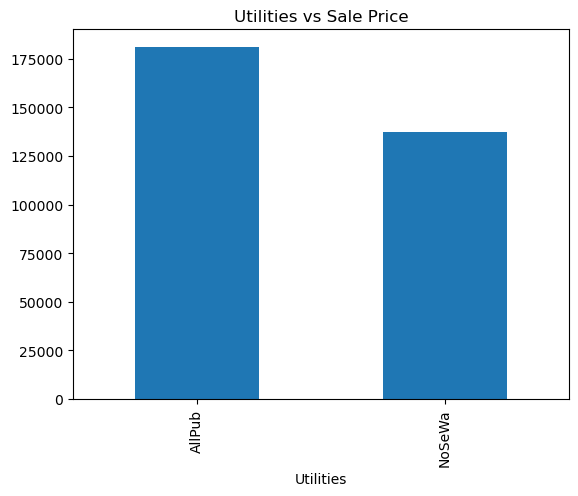

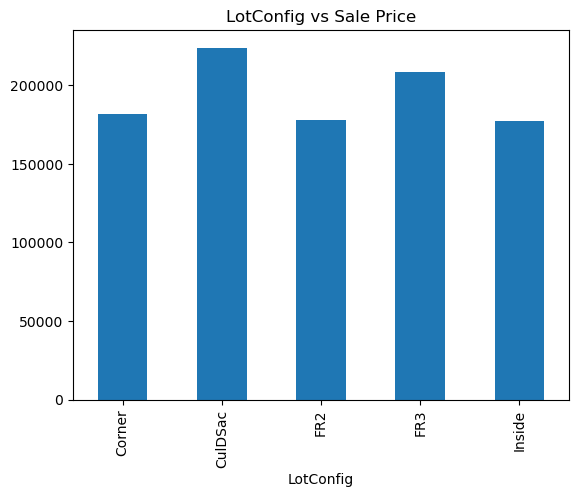

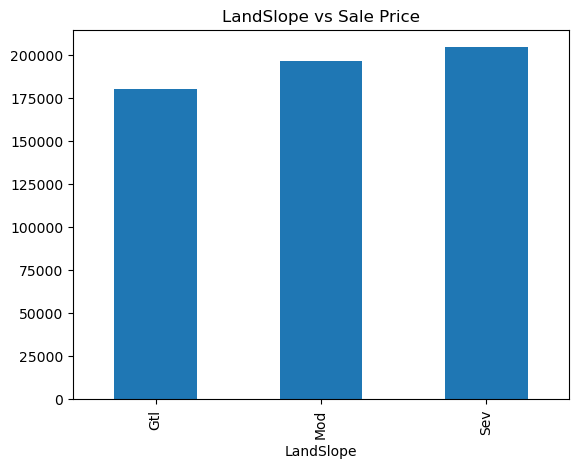

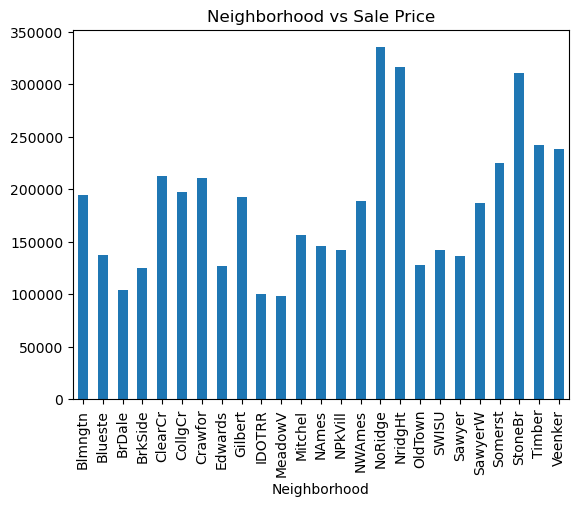

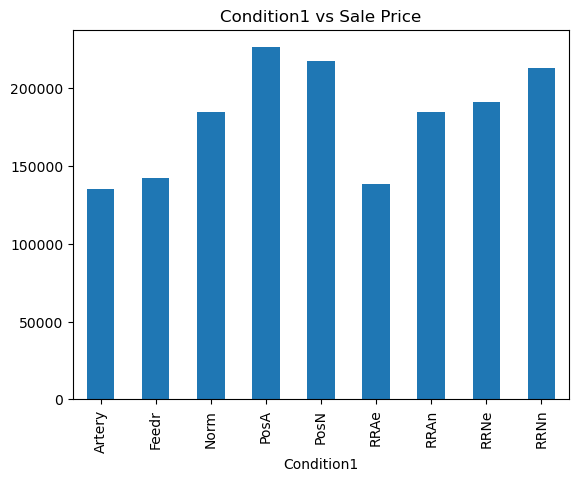

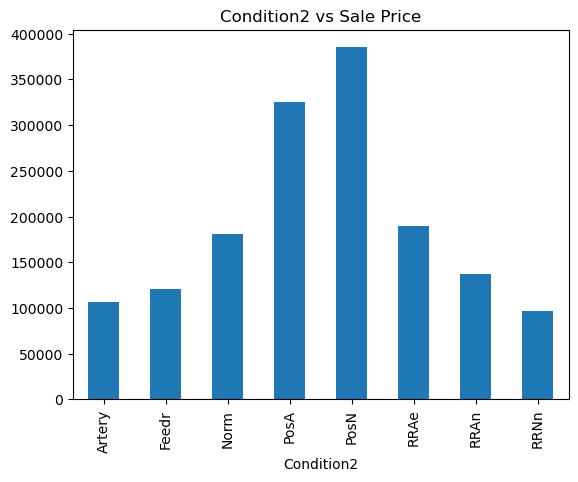

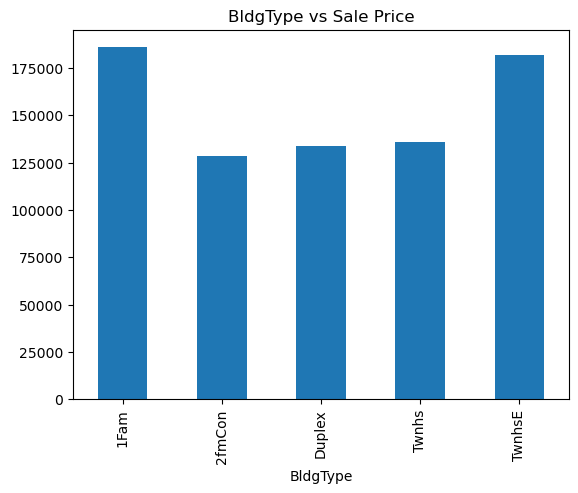

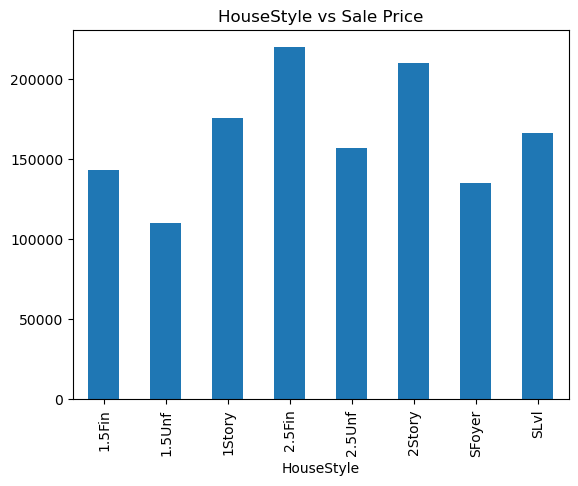

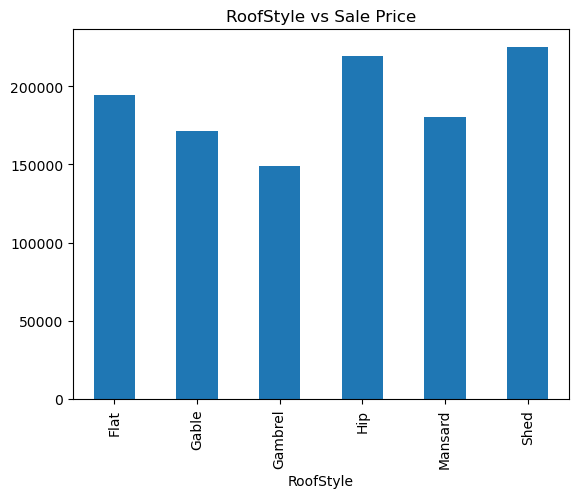

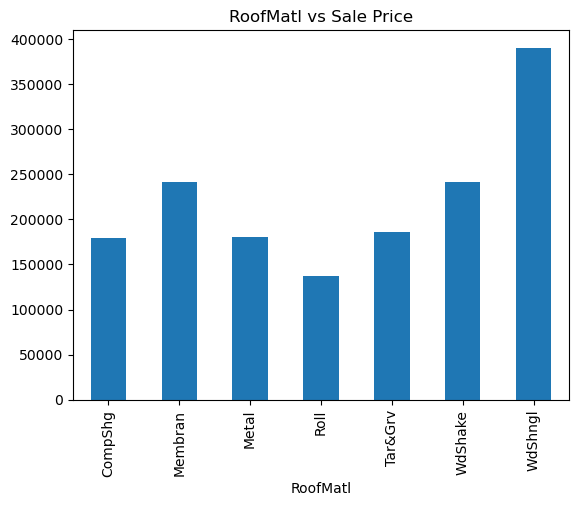

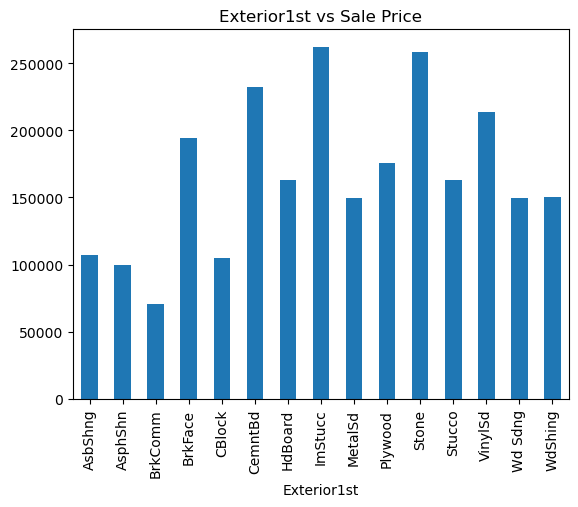

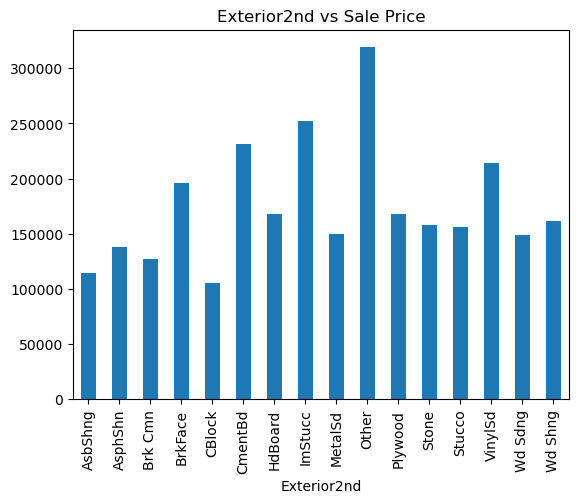

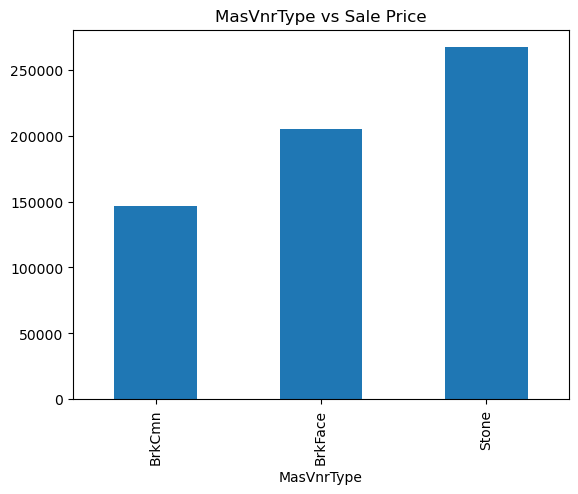

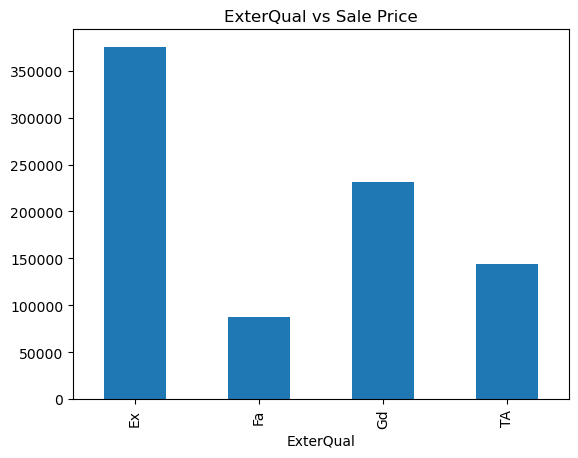

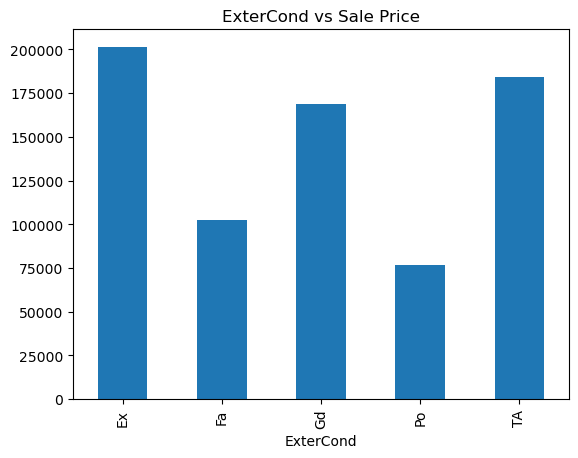

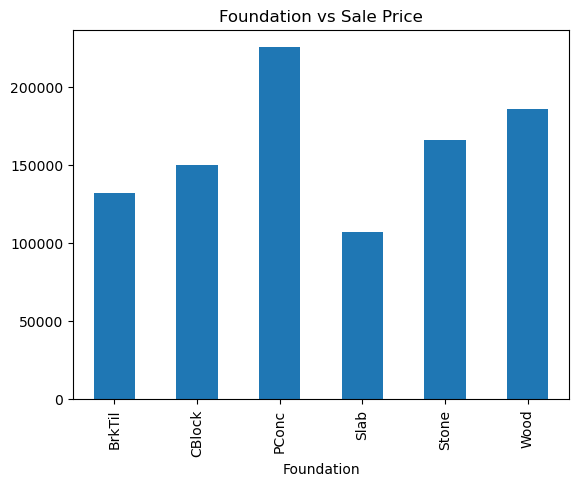

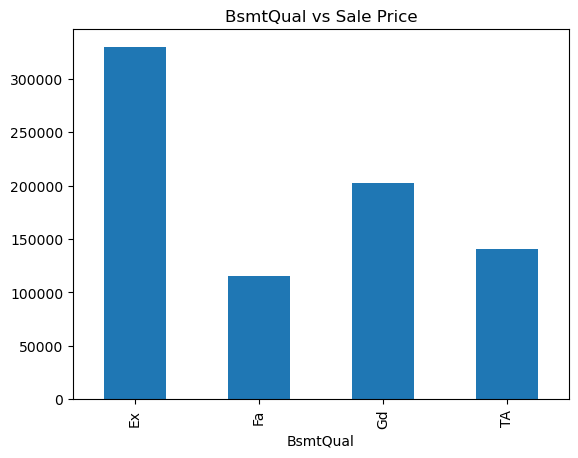

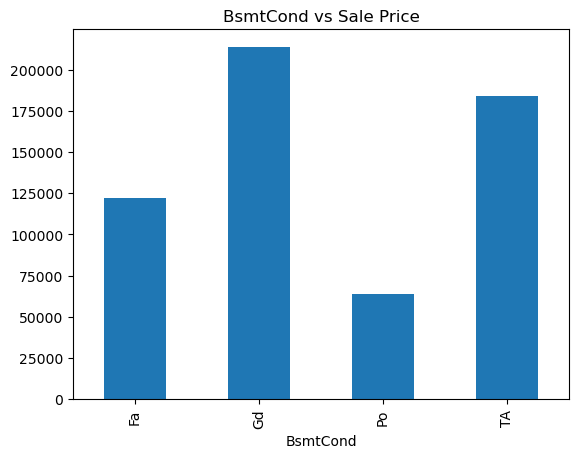

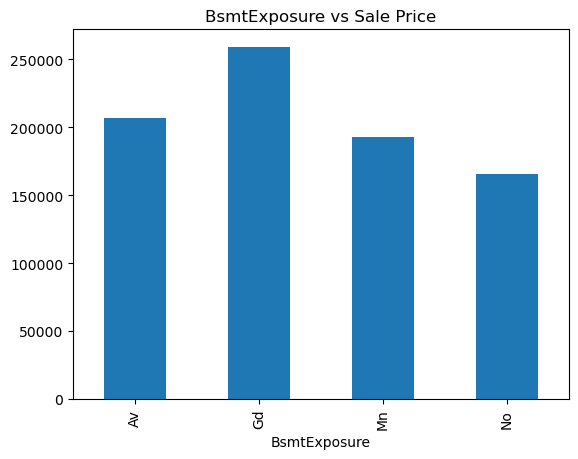

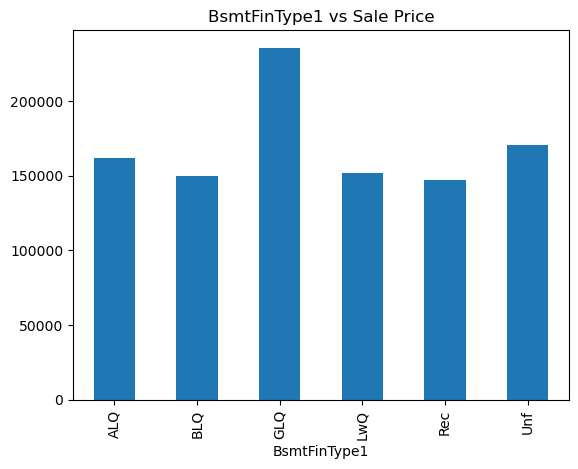

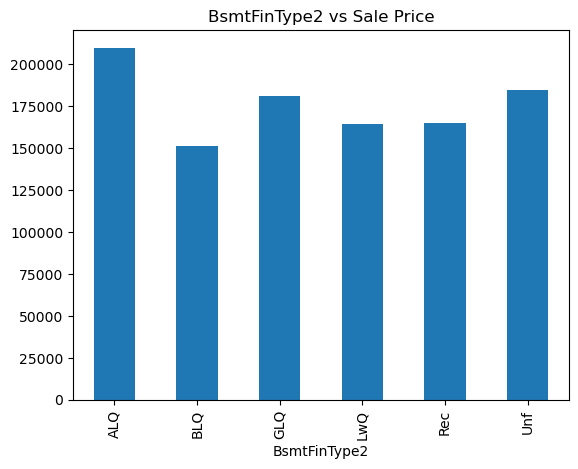

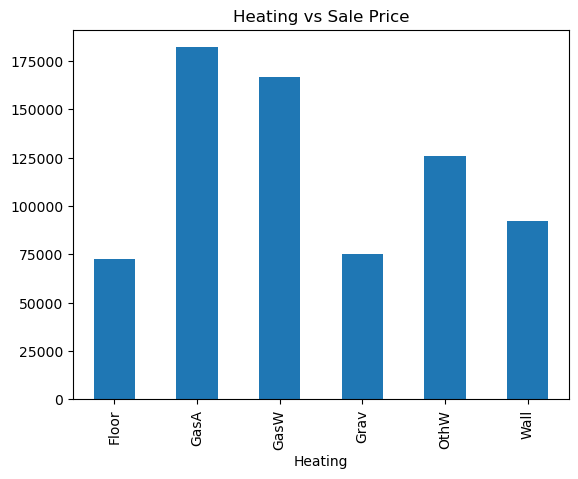

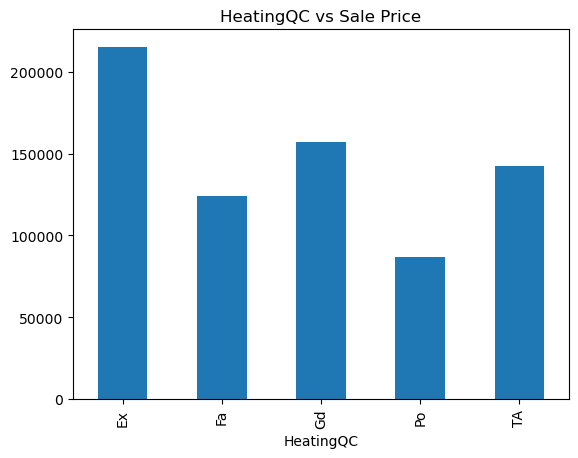

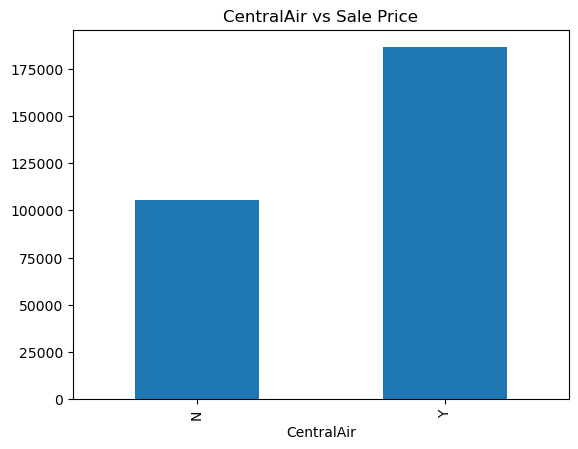

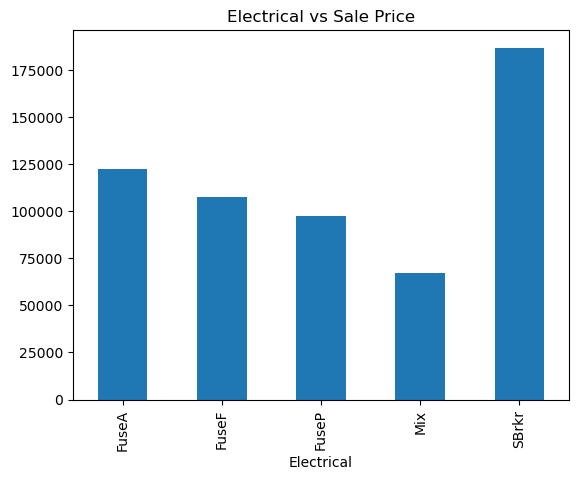

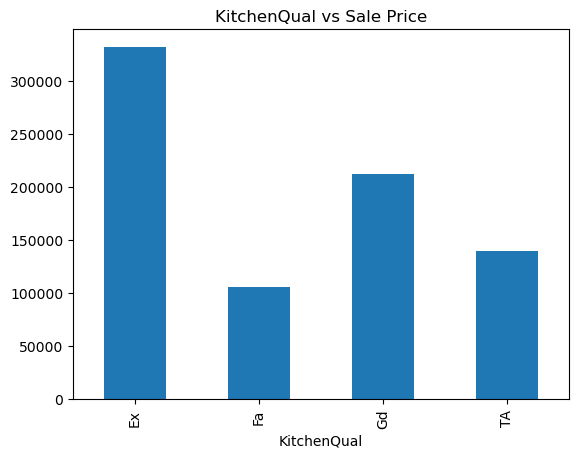

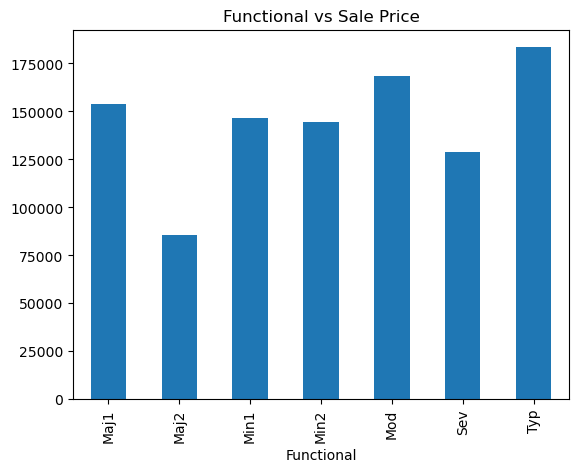

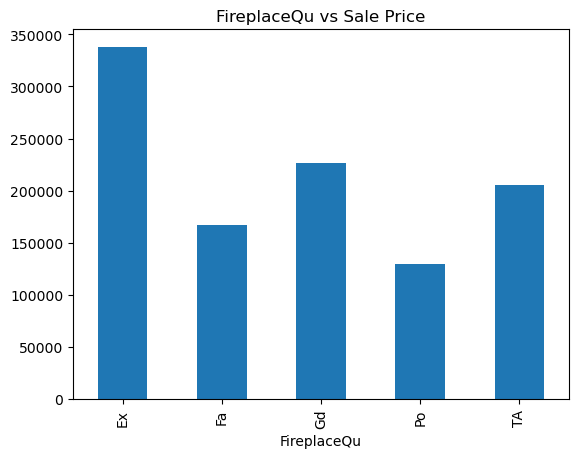

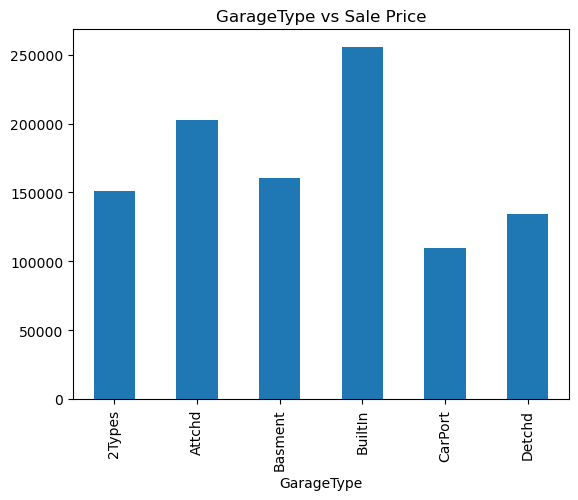

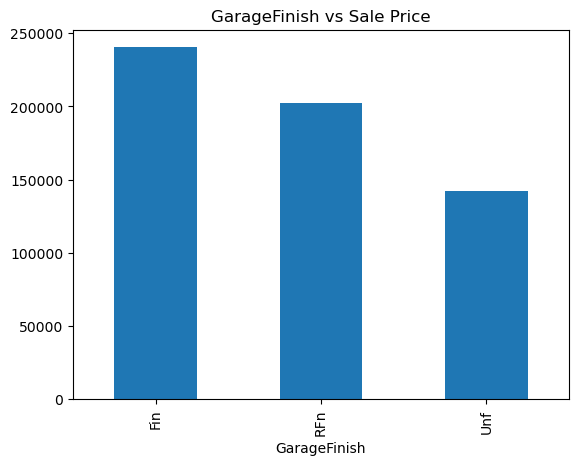

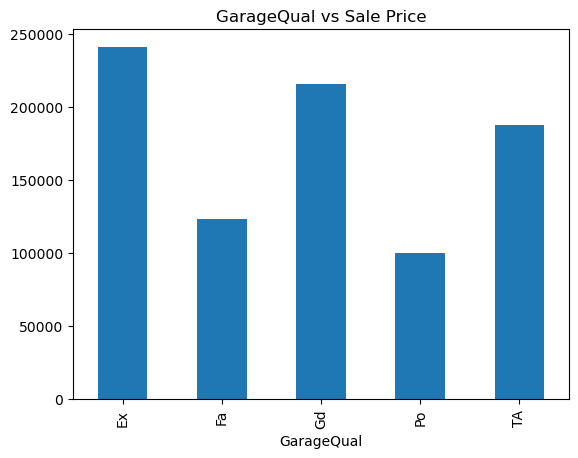

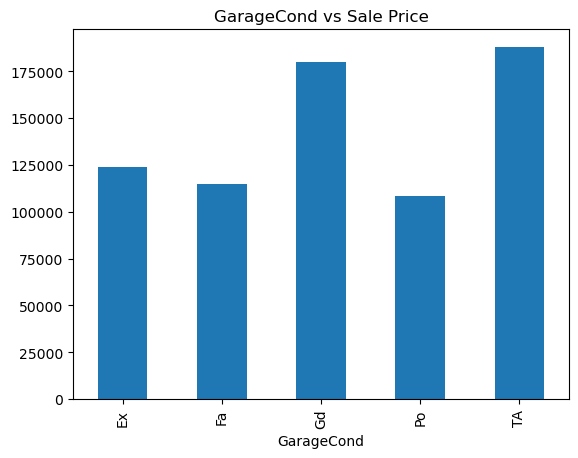

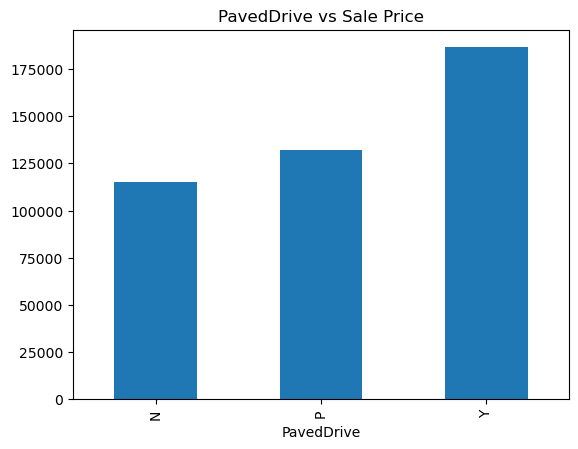

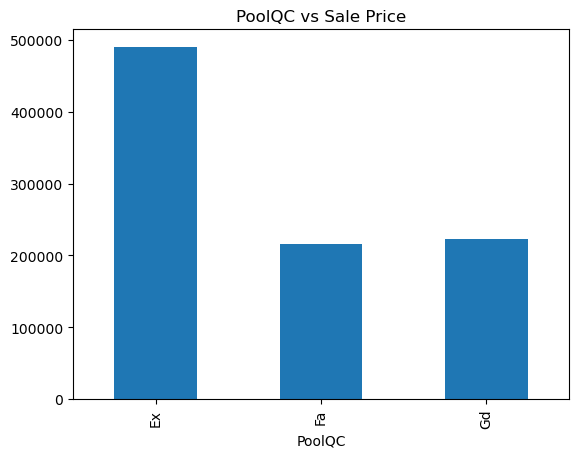

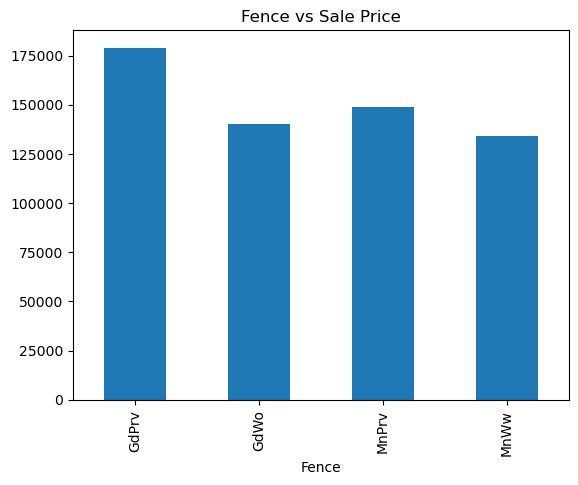

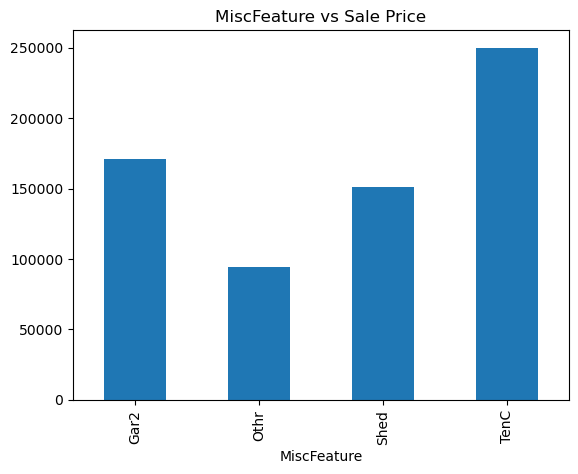

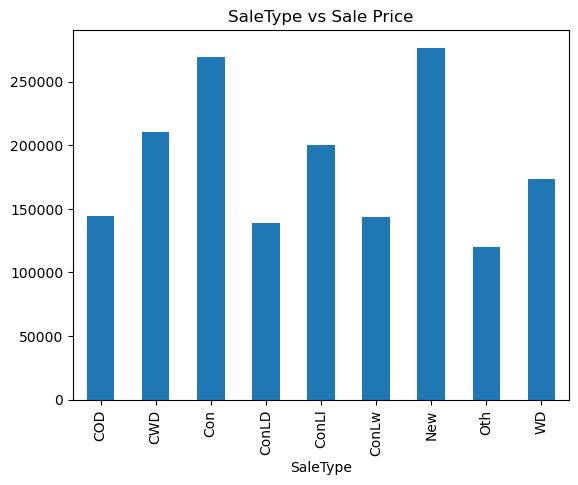

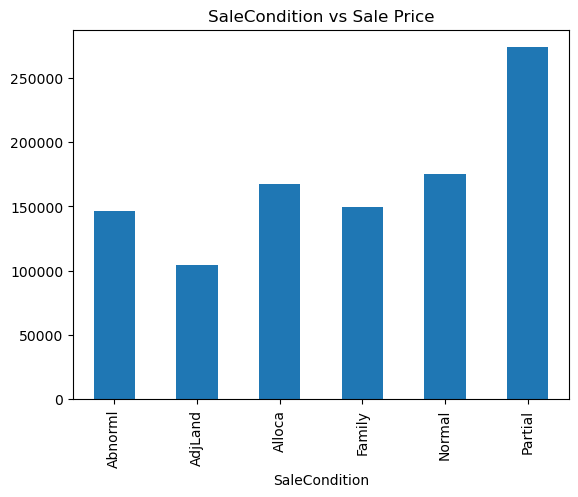

In [19]:
for feature in categorical_features:
    train_data.groupby(feature)['SalePrice'].mean().plot.bar()
    plt.title(feature + ' vs Sale Price')
    plt.show()

DATA CORRELATION

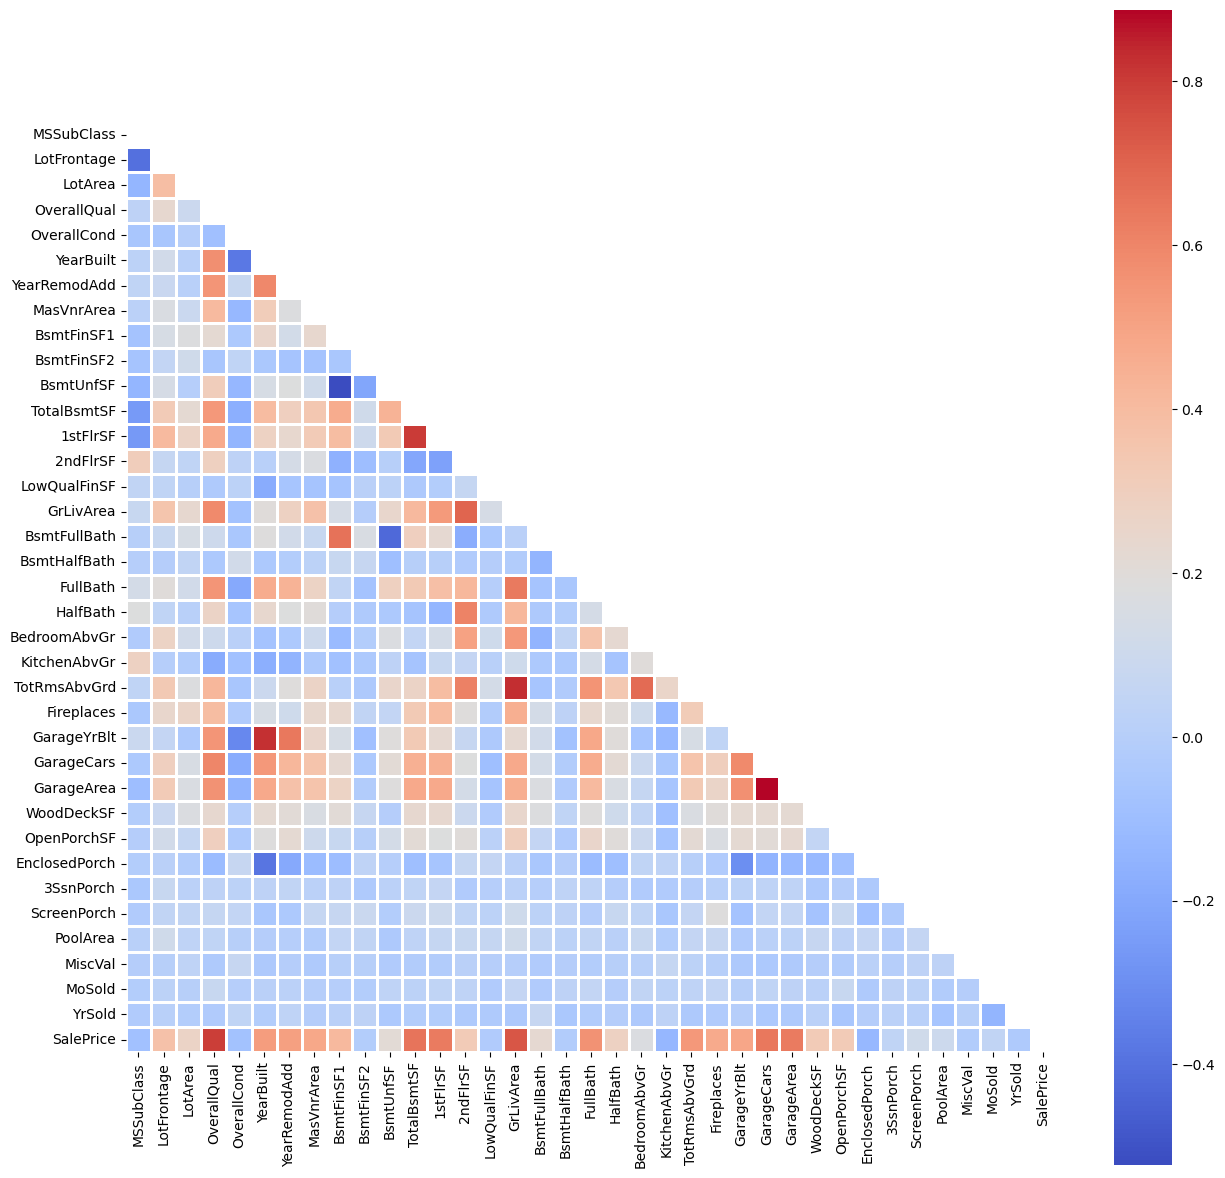

In [21]:
#Correlation map to see how features are correlated
numeric_columns = train_data.select_dtypes(include=['float64', 'int64']).columns
corr_train = train_data[numeric_columns].corr()
mask = np.triu(corr_train.corr())
plt.figure(figsize=(15, 15))
sns.heatmap(corr_train, annot=True, fmt='.1f', cmap='coolwarm', square=True, mask=mask, linewidth=1, cbar=True)
plt.show()

# DATA PREPROCESSING

TARGET VARIABLE

SalePrice is the variable we need to predict. So let's do some analysis on this variable first.

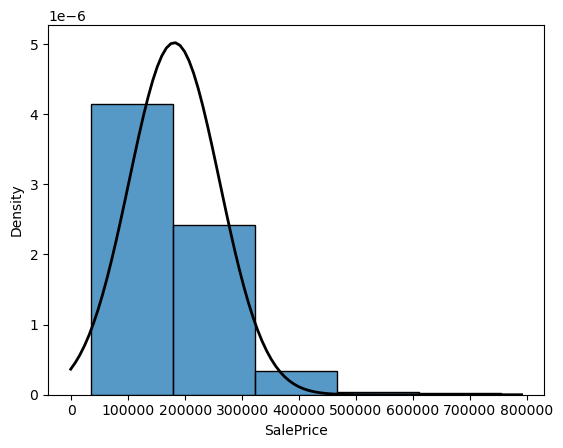

In [25]:
sns.histplot(train_data['SalePrice'], kde=False, stat="density", bins=5)
param = stats.norm.fit(train_data['SalePrice'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, *param)
plt.plot(x, p, 'k', linewidth=2)
plt.show()

From the above plot we can infer that the target variable is right skewed and the distribution does not follow normal distribution. As (linear) models love normally distributed data, we need to transform this variable and make it more normally distributed. Log Tranformation seems like a better fit, hence we apply logorithmic transformation on "SalePrice" column.

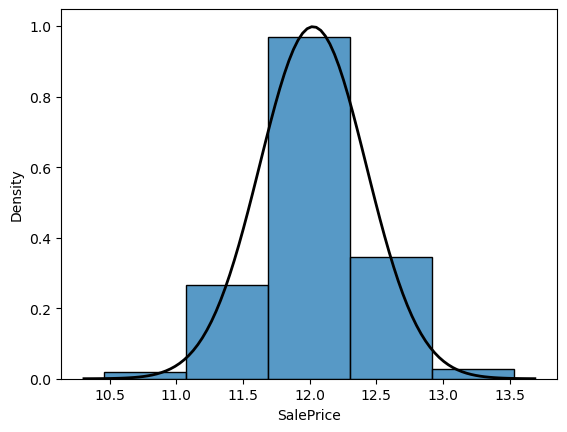

In [27]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train_data["SalePrice"] = np.log1p(train_data["SalePrice"])
y = train_data["SalePrice"]


sns.histplot(train_data['SalePrice'], kde=False, stat="density", bins=5)
param = stats.norm.fit(train_data['SalePrice'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, *param)
plt.plot(x, p, 'k', linewidth=2)
plt.show()

The skew seems now corrected and the data appears more normally distributed.

In [29]:
# Merging the train and test data in the same dataframe
ntrain = train_data.shape[0]
ntest = test_data.shape[0]
y_train = train_data.SalePrice.values
data = pd.concat([train_data.drop("SalePrice",axis=1),test_data])

In [30]:
print("data size is : {}".format(data.shape))

data size is : (2917, 79)


# MISSING DATA

In [32]:
data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
MasVnrType,60.541652
FireplaceQu,48.680151
LotFrontage,16.660953
GarageFinish,5.450806
GarageQual,5.450806
GarageCond,5.450806


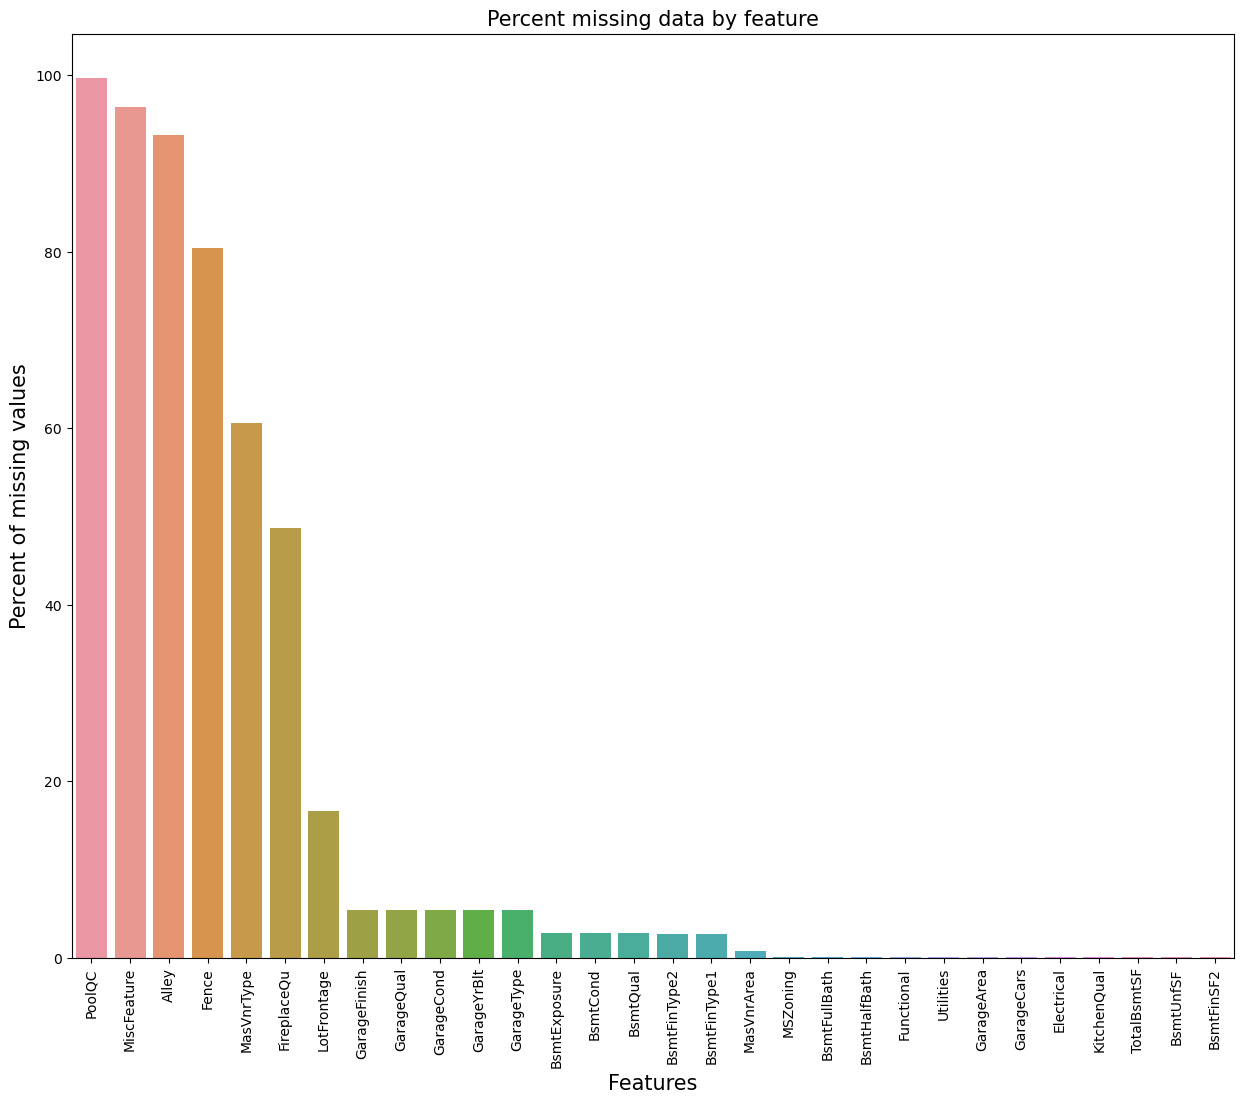

In [33]:
fig, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation=90)
sns.barplot(x=data_na.index, y=data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
plt.show()

In [34]:
data = data.drop(["PoolQC", "MiscFeature", "Alley", "Fence"], axis = 1)

In [35]:
data.shape

(2917, 75)

# DATA IMPUTATION

Categorical Values 

Since the below features have more NA values, instead of droping the columns we simple impute them with "None" and "Mode"

FireplaceQu : data description says NA means "no fireplace"
GarageType, GarageFinish, GarageQual and GarageCond : Replacing missing data with None
BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 : For all these categorical basement-related features, NaN means that there is no basement.

In [40]:
features_nonefill = ["FireplaceQu", "GarageCond", "GarageQual", "GarageFinish", "GarageType", "BsmtCond", "BsmtExposure", "BsmtQual", "BsmtFinType2", "BsmtFinType1", "MasVnrType"]
#filling NA with "None"
data[features_nonefill] = data[features_nonefill].fillna("None")

MSZoning (The general zoning classification) : 'RL' is by far the most common value. So we can fill in missing values with 'RL' Utilities : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA. Since this feature has mostly 'AllPub', we can set that for the missing value. 
Electrical : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value. KitchenQual: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual. 
Exterior1st and Exterior2nd : Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string SaleType : Fill in again with most frequent which is "WD"

In [42]:
features_modefill = ["MSZoning", "Utilities", "Exterior1st", "Exterior2nd", "SaleType", "Electrical", "KitchenQual","Functional"]
#grouping by Neighborhood and filling NA with "Mode" i.e Most-frequently occuring
data[features_modefill] = data.groupby("Neighborhood")[features_modefill].transform(lambda x:x.fillna(x.mode()[0])) 

Numeric Values: Since the below features have more NA values, instead of droping the columns we simple impute them with "median" and "0"

LotFrontage : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.

In [45]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

GarageYrBlt, GarageArea and GarageCars: Replacing missing data with 0 MasVnrArea: NA most likely means no masonry veneer for these houses. We can fill 0 for the area. BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath : missing values are likely zero for having no basement

In [47]:
features_zerofill = ["GarageArea", "GarageYrBlt", "GarageCars", "MasVnrArea", "BsmtHalfBath", "BsmtFullBath", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF"]
#filling NA with 0
data[features_zerofill] = data[features_zerofill].fillna(0)

Is there any remaining missing value ?

In [49]:
#Check remaining missing values if any 
data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :data_na})
missing_data.head()

,Missing Ratio


It means no missing value.

# FEATURE ENGINEERING

Since area related features are very important to determine house prices, we add one more feature which is the total area of basement, first and second floor areas of each house

In [53]:
# Adding total sqfootage feature 
data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']

# ENCODING CATEGORICAL FEATURES

By looking at the data we can say that "MSSubClass", "OverallCond", "YrSold", and "MoSold" are Categorical Variables, so we transform them into dtype : object

In [56]:
data[["MSSubClass", "OverallCond", "YrSold", "MoSold"]] = data[["MSSubClass", "OverallCond", "YrSold", "MoSold"]].astype(str)


Label Encoding some categorical variables that may contain information in their ordering set

In [58]:
from sklearn.preprocessing import LabelEncoder 
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(data[c].values)) 
    data[c] = lbl.transform(list(data[c].values))     
print('Shape data: {}'.format(data.shape))

Shape data: (2917, 76)


# NORMALIZING SKEWED DATA

Since our data is skewed we apply boxcox normalization and transform the skwed data

In [61]:
skewed = [
    'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
    'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
    'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
    'ScreenPorch', 'PoolArea', 'LowQualFinSF', 'MiscVal'
]
skew_features = np.abs(data[skewed].apply(lambda x: skew(x)).sort_values(ascending=False))
high_skew = skew_features[skew_features > 0.3]
skew_index = high_skew.index
from scipy.special import boxcox1p
lam = 0.15
for i in skew_index:
    data[i] = boxcox1p(data[i], lam) # Normalizing Skewed Data

# Feature Scaling 

We use Robust Scaling because Robust Scaler algorithms scale features that are robust to outliers and mostly work as min-max scaler

In [64]:
cols = data.select_dtypes(np.number).columns
data[cols] = RobustScaler().fit_transform(data[cols])

# Getting dummy categorical features

In [66]:
data = pd.get_dummies(data) 

In [67]:
data.shape

(2917, 214)

# Getting the new train and test sets.

In [69]:
train_data = data[:ntrain]
test_data = data[ntrain:]

In [70]:
train_data.shape

(1458, 214)

In [71]:
test_data.shape

(1459, 214)

In [72]:
train_data.columns.values

array(['MSSubClass', 'LotFrontage', 'LotArea', 'Street', 'LotShape',
       'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'HeatingQC', 'CentralAir', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
       'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'TotalSF',
       'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL',
       'MSZoning_RM', 'LandContour_Bnk', 'LandContour_HLS',
    

# MODELING

CROSS VALIDATION STRATEGY

KFold Cross-Validation: KFold cross-validation is a technique for assessing the performance of a machine learning model. It involves splitting the dataset into k folds (subsets), training the model on k-1 folds, and validating on the remaining fold. This process is repeated k times, with each fold used as the validation set exactly once.
Root Mean Squared Error (RMSE): RMSE is a metric commonly used in regression problems to measure the average magnitude of the errors between predicted and actual values. It is the square root of the mean squared error.
We use the cross_val_score function of Sklearn. However this function has not a shuffle attribut, we add then one line of code, in order to shuffle the dataset prior to cross-validation

In [76]:
n_folds = 5
kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train_data.values)

def rmsle_cv(model):
    rmse= np.sqrt(-cross_val_score(model, train_data.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

Hyper Parameter Optimization

We use Randomized Search for Optimization, since it is more efficient. We define a function which takes in model and parameter grid as inputs , uses Radomized search and returns best hyperparameters

In [79]:
def perform_random_search(model, param_distributions, train_data, y_train, cv=kf, n_iter=10):
    if model == xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4):
        searchxg = RandomizedSearchCV(estimator = model, param_distributions = param_distributions, cv=kf, n_iter = n_iter, n_jobs=4, random_state=0, verbose=True)
        random_search.fit(train_data, y_train,early_stopping_rounds=5,verbose=True)
    else:
        random_search = RandomizedSearchCV(model,param_distributions=param_distributions,n_iter=n_iter,cv=kf,n_jobs=4, random_state=0, verbose=True)
        random_search.fit(train_data, y_train)
    print("Best Hyperparameters:")
    print(random_search.best_params_)

# BASE MODELS HYPERPARAMETERS

In [81]:
lasso_param_distributions = {'alpha': np.logspace(-4, 1, 100)}
lasso_best_params = perform_random_search(Lasso(), lasso_param_distributions, train_data, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters:
{'alpha': 0.0006428073117284319}


In [82]:
kernel_ridge_param_distributions = {'alpha': np.logspace(-1, 4, 400)}
kernel_ridge_best_params = perform_random_search(KernelRidge(), kernel_ridge_param_distributions, train_data, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters:
{'alpha': 0.5647805074067554}


In [83]:
elastic_net_param_distributions = {'alpha': np.logspace(-4, 1, 100), 'l1_ratio':np.linspace(0.1, 0.9, 9)}
elastic_net_best_params = perform_random_search(ElasticNet(), elastic_net_param_distributions, train_data, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters:
{'l1_ratio': 0.7000000000000001, 'alpha': 0.0005722367659350221}


In [84]:
gradient_boosting_param_distributions = {'n_estimators': [1000, 2000, 3000],"max_features": np.linspace(0.2, 0.7, 6), "learning_rate": [0.01, 0.05, 0.1, 0.2]}
gradient_boosting_best_params = perform_random_search(GradientBoostingRegressor(), gradient_boosting_param_distributions, train_data, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters:
{'n_estimators': 2000, 'max_features': 0.3, 'learning_rate': 0.05}


# Base models

LASSO Regression :
This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's Robustscaler() method on pipeline

In [87]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

Elastic Net Regression :
again made robust to outliers

In [89]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

Kernel Ridge Regression :

In [91]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

Gradient Boosting Regression :
With huber loss that makes it robust to outliers

In [93]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,max_depth=4, max_features='sqrt',min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =5)

# Base models scores

Let's see how these base models perform on the data by evaluating the cross-validation rmsle error

In [96]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std())) # mean & the standard deviation


Lasso score: 0.1101 (0.0062)



In [97]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1101 (0.0063)



In [98]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1125 (0.0052)



In [99]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1186 (0.0086)



# Stacking models

We add a meta-model on averaged base models and use the out-of-folds predictions of these base models to train our meta-model.

In [102]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

We averaged Enet, KRR and Gboost, then we add lasso as meta-model.

In [104]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1075 (0.0066)


In [105]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [106]:
stacked_averaged_models.fit(train_data.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train_data.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test_data.values))
print(rmsle(y_train, stacked_train_pred))

0.08071025447522436


In [107]:
ensemble = stacked_pred

In [108]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)